<a href="https://colab.research.google.com/github/Gab2697/Human-Activity-Recognition/blob/master/CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

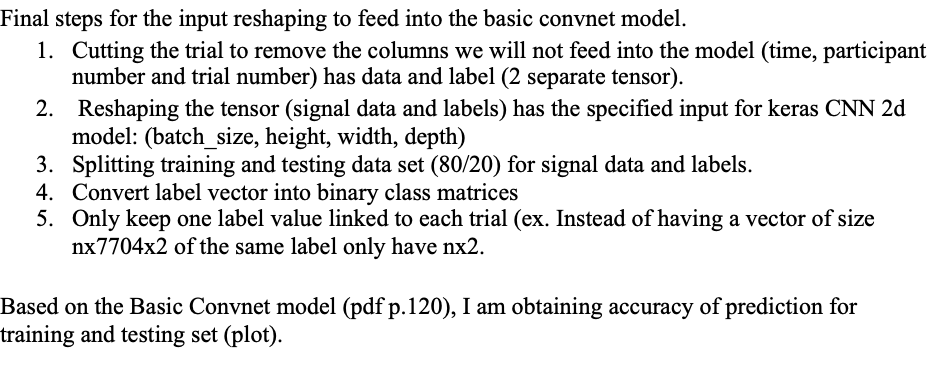

In [1]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy import signal
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Open tensor (see pre-processing_CNN code)

In [3]:
def open_pickle(path_pickle):
  f = open(path_pickle, 'rb')
  T = pickle.load(f)
  f.close()

  return T

In [4]:
#This tensor includes participant: 3,4,5,7,8,9,10,11,12,20,24
TT= open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TT.pickle')

Final input data reshaping

In [5]:
from tensorflow.keras.utils import to_categorical

#========Initial cutting========
#X-data with shape ((1926frames x 4sec)x(80trials x 2surfaces x n-participants) x 4channels)
X=TT[:, :, 1:5].numpy() #size: (7704, 320, 4)
#Y-categorical encoded label = 1 for asphalt and 0 for grass 
y=TT[:,:,4].numpy() 
#number trials
num_trials= TT.shape[1]

#========Sreshaping into the specific intut format========S 
#keras CNN is looking for X= (batch_size, height, width,depth)
X_reshape = X.reshape((num_trials,7704, 4, 1))
y=y.reshape((num_trials,7704,1))
print("Data shape:", X_reshape.shape) 
print("Label shape:", y.shape)

#========Splitting the data into training and testing sets========S
#data set for training and testing the model
train_size= int(0.8*num_trials) 
X_train= X_reshape[0:train_size,:,:,:]
X_test=X_reshape[train_size:num_trials,:,:,:]
#labels for train and test
y_train=y[0:train_size,:,:] 
y_test=y[train_size:num_trials,:,:]

# ========convert class vectors to binary class matrices========
label_train = to_categorical(y_train, 2)
label_test = to_categorical(y_test, 2)

#========only keeping one label for each trials========
#(instead of a complete vector of the same number)
label_train= label_train[:,0,:]
label_test=label_test[:,0,:]

print("Data shape train:",X_train.shape,"Data shape test:",X_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)

Data shape: (1710, 7704, 4, 1)
Label shape: (1710, 7704, 1)
Data shape train: (1368, 7704, 4, 1) Data shape test: (342, 7704, 4, 1) Label shape train: (1368, 2) Label shape test: (342, 2)


#CNN

In [6]:
from keras import layers 
from keras import models

#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3852, 2, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3852, 2, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1926, 1, 64)       18496     
                                                                 
Total params: 28,064
Trainable params: 28,064
Non-traina

In [7]:
#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3852, 2, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3852, 2, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1926, 1, 64)       18496     
                                                                 
 flatten (Flatten)           (None, 123264)            0

In [ ]:
#Hack:By writing just the three lines of code you can increase your Ram from 12GB to 25 GB???
a = []
while 1:
    a.append("1")

In [ ]:
# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trials) 

Epoch 1/5


In [ ]:
#test accuracy
test_loss, test_acc = model.evaluate(X_test, label_test)
test_acc

In [ ]:
#Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss'] 
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss') #“bo” is for “blue dot.”
plt.title('Training loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy_values = history_dict['accuracy']
plt.plot(epochs, accuracy_values, 'b', label='Validation loss')#“b” is for “solid blue line.”
plt.title('Accuracy of training set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()